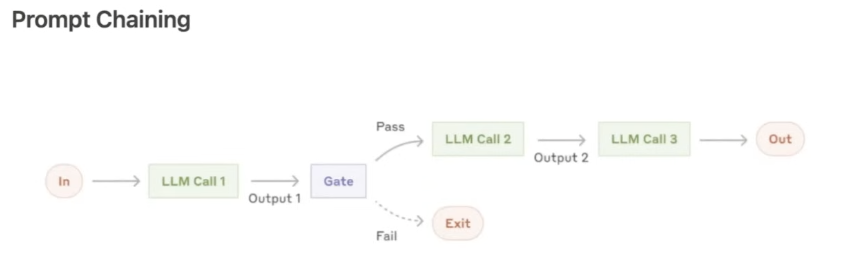

In [1]:
"""
本代码旨在完成一个讲joke的agent
 take a topic,LLM makes a joke,check the joke,improve it twice
"""
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph,START,END
import os

class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke:str

llm = ChatOpenAI(
    model_name="qwen-max-latest",
    base_url=os.getenv("LLM_BASE_URL"),
    api_key=os.getenv("LLM_API_KEY")
)

/Users/daijunjie/miniconda3/envs/langchain-env/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [8]:
from langchain_core.tools import tool


# @tool
def generate_joke(state:State):
    """First LLM call to generate initial joke"""
    msg = llm.invoke(f"write a short joke about {state['topic']}")
    return {"joke":msg.content}

# @tool
def improve_joke(state:State):
    """Second LLM call to improve the joke"""
    msg = llm.invoke(f"improve this joke funnier by adding wordplay:{state['joke']}")
    return {"improved_joke":msg.content}

# @tool
def polish_joke(state:State):
    """Third LLM call to polish the joke"""
    msg = llm.invoke(f"Add a surprising twist to this joke:{state['improved_joke']}")
    return {"final_joke":msg.content}

def check_punchline(state:State):
    """Gate function to check if the joke has a punchline"""
    if "?" in state['joke'] or "!" in state['joke']:
        return "Pass"
    # return {"final_joke":msg.content}
    return "Fail"

graph = StateGraph(State)
graph.add_node("generate_joke",generate_joke)
graph.add_node("improve_joke",improve_joke)
graph.add_node("polish_joke",polish_joke)
# graph.add_node("check_punchline",check_punchline)
graph.add_edge(START,"generate_joke")
graph.add_conditional_edges(
    "generate_joke",
    check_punchline,
    {
        "Pass": "improve_joke",
        "Fail": END
    }
)
graph.add_edge("improve_joke","polish_joke")
graph.add_edge("polish_joke",END)

agent = graph.compile()

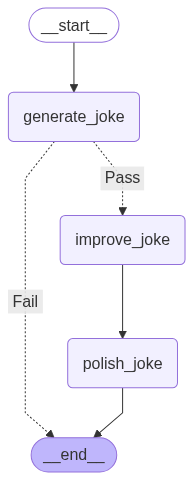

In [5]:
# 可视化agent
from IPython.display import Image, display
display(Image(agent.get_graph().draw_mermaid_png()))


In [10]:
for event in agent.stream(
    {"topic":"cat"}
):
    print(event)

{'generate_joke': {'joke': 'Why was the cat sitting on the computer?\n\nBecause it wanted to keep an eye on the mouse! 🐱🖱️'}}
{'improve_joke': {'improved_joke': 'Why was the cat sitting on the computer?  \n\nBecause it wanted to keep a *purr-fect* eye on the mouse—and make sure it didn’t *click* away! 🐱🖱️'}}
{'polish_joke': {'final_joke': 'Sure, here\'s a surprising twist to your joke:\n\nWhy was the cat sitting on the computer?  \n\nBecause it wanted to keep a *purr-fect* eye on the mouse—and make sure it didn’t *click* away! 🐱🖱️  \n\nBut when the cat finally caught the mouse, it realized the mouse wasn’t real… it was just a wireless trackpad shaped like a rodent. Now the cat spends its days trying to figure out why humans are so obsessed with their "magic gestures" instead of proper hunting! ✋'}}


In [ ]:
state = agent.invoke({"topic":"cat"})
for k,v in state.items():
    print(k,': ',v)  


{'topic': 'cat', 'joke': 'Why was the cat sitting on the computer?\n\nBecause it wanted to keep an eye on the mouse! 🐱🖱️', 'improved_joke': 'Why was the cat sitting on the computer?  \n\nBecause it wanted to keep a *paw* on the situation and make sure the mouse didn’t *click* away! 🐱🖱️', 'final_joke': "Sure, here's a surprising twist to your joke:\n\nWhy was the cat sitting on the computer?  \n\nBecause it wanted to keep a *paw* on the situation and make sure the mouse didn’t *click* away—**but little did it know, the mouse had already built its own underground network of tunnels behind the desk!** 🐱🖱️鼹鼠"}
